<a href="https://colab.research.google.com/github/SenneDG/PhishingDetection/blob/main/SmishingDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMS Smishing Detection - Machine Learning Project

## Data Analysis

In [2]:
from google.colab import drive
drive.mount('/content/drive');

MessageError: Error: credential propagation was unsuccessful

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

RANDOM_STATE = 1337

DATA_PATH = Path.cwd()/"drive"/"MyDrive"/"ML"/"dataset";

# Read the dataset from csv file
dataset = pd.read_csv(DATA_PATH/"Dataset_5971.csv")

# Seperate the dataset into labels and features

# Some of the data is mislabeled (there are examples with both label "Spam" and "spam" for example)
y = dataset["LABEL"].str.lower() # Labels

X = dataset.loc[:, dataset.columns != "LABEL"].copy() # Features

# there is probably a better way to do this
for col in X.columns:
    if col != 'TEXT':
        X[col] = X[col].str.lower()

np.testing.assert_array_equal(y.index.values, X.index.values);

#dataset.head()
dataset.loc[[5830, 5418, 3060, 2415, 3046], :]

FileNotFoundError: ignored

### Characteristics of the dataset

Now we can take a look at the characteristics of our dataset. We will take a look at the amount of entries, if there is any missing data and the amount of unique data in every column. And lastly we will take a look at the proportion of the labels in our dataset.

There are 5971 entries within the dataset. Which sufficies the project requirements. Also there is no missing data in the dataset and we have enough unique **TEXT** data

It becomes clear that this dataset is quite unbalanced, and as such we should take this into account wihtin our machine learning model.

Number of rows: 5971
Number of columns: 5
Missing values:
LABEL    0
TEXT     0
URL      0
EMAIL    0
PHONE    0
dtype: int64
Number of unique values in each column:
LABEL       5
TEXT     5949
URL         2
EMAIL       2
PHONE       2
dtype: int64


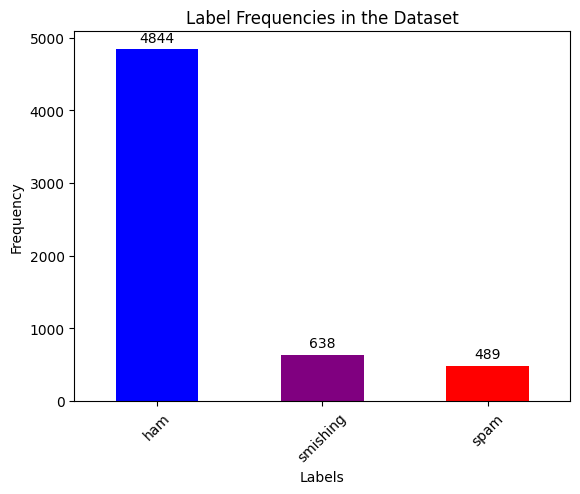

In [ ]:
def dataStats(X, y):
    # Number of rows and columns
    num_rows, num_cols = dataset.shape
    print("\033[1mNumber of rows:\033[0m", num_rows)
    print("\033[1mNumber of columns:\033[0m", num_cols)

    # Missing values
    missing_values = dataset.isnull().sum()
    print("\033[1mMissing values:\033[0m")
    print(missing_values)

    # Number of unique values in each column
    unique_values = dataset.nunique()
    print("\033[1mNumber of unique values in each column:\033[0m")
    print(unique_values)

    n_obvs = y.shape[0]
    label_count = y.value_counts()
    bars = label_count.plot(kind='bar', color=['blue', 'purple', 'red'])
    plt.title('Label Frequencies in the Dataset')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

    for bar in bars.patches:
        plt.annotate(format(bar.get_height(), '.0f'),
                    (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                    size=10, xytext=(0, 8),
                    textcoords='offset points')

    plt.show()

dataStats(X, y)

## How to deal with unbalanced data:

- *Oversampling*: Involves adding more examples from the minority class
- *Undersampling*: Involves removing examples from the majority class
- *Penalized Models*: These impose an additional cost on the model for making classification mistakes on the minority class during training (for example, many scikit-learn models accept a `class_weights` parameters, which may be set to `class_weights='balanced'` in order to account for this)
- *Data augmentation*: This technique is especially useful when dealing with datasets like images where new data can be created by cropping, rotating, flipping, etc.

It is important to point out that this should be done before training and ***data splitting***:

X_train.shape (4179, 4) y_train.shape (4179,)
X_test.shape (1792, 4) y_test.shape (1792,)
Number of rows: 5971
Number of columns: 5
Missing values:
LABEL    0
TEXT     0
URL      0
EMAIL    0
PHONE    0
dtype: int64
Number of unique values in each column:
LABEL       5
TEXT     5949
URL         2
EMAIL       2
PHONE       2
dtype: int64


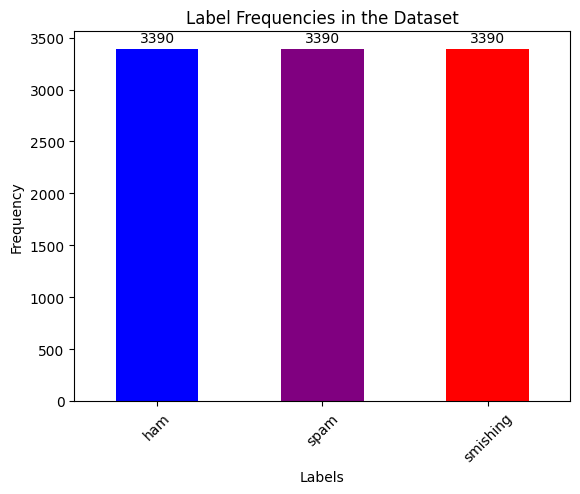

X_train.shape (10170, 4) y_train.shape (10170,)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import RandomOverSampler

# Lectures advised reserving 20-40% of your data set for testing.
TEST_SIZE = 0.3

# the stratify parameter makes it such that in the split the class labels are
# roughly the same proportion as in the original data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

# Using RandomOverSampler to oversample the minority classes
# it is better to do this after the split, as otherwise there can be
# some
sm = RandomOverSampler(random_state=RANDOM_STATE)
X_train, y_train = sm.fit_resample(X_train, y_train)

dataStats(X_train, y_train)

print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)

## Text datapreprocessing

1. Text Cleaning: This is the initial step in text preprocessing, which involves removing unnecessary and redundant data

2. Tokenization: This step involves splitting the text into individual words or tokens.

3. Stopword Removal: Stopwords are the most common words in a language like 'the', 'is', 'in', 'for', etc.

4. Stemming/Lemmatization: These techniques are used to reduce a word to its root form.

5. Vectorization: After preprocessing, the text data needs to be converted into numerical form for the machine learning model.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

class TextPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = []
        for text in X:
            text = re.sub(r'\d+', '', text)
            text = re.sub(r'\W+', ' ', text)
            text = text.lower()

            # there is no need for tokenization, the vectorizer handles this for us
            # words = word_tokenize(text)
            # words = [self.lemmatizer.lemmatize(word) for word in words if word not in self.stop_words]
            X_transformed.append(text)

        return X_transformed

In [ ]:
# do this if nltk complains about downloading something
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Assignment Models

For the classification model based on the assignment code, we've decided to utilize the logistic regression, and implement it into a sklearn compatible class.

To do multiclass classification we can implement a one-vs-all strategy in the pipeline using a `OneVsRestClassifier`.

In [ ]:
# @title Logistic Classifier (assignment 2)
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class LogisticClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, lambda_=1, iter_=1000, learning_rate_=0.01):
        self.lambda_ = lambda_
        self.iter_ = iter_
        self.learning_rate_ = learning_rate_
        self.w = None
        self.b = None

    def predict(self, X):
        z = np.dot(X, self.w) + self.b
        f = self.sigmoid(z)
        return (f > 0.5).astype(int)

    def fit(self, X, y):
        m, n = X.shape

        print(X.shape)

        self.w = np.zeros((n, 1))
        self.b = 0

        # Gradient descent
        for _ in range(self.iter_):  # number of iterations
            dj_db, dj_dw = self.compute_gradient_reg(X, y, self.w, self.b, self.lambda_)
            self.w = self.w - self.learning_rate_ * dj_dw
            self.b = self.b - self.learning_rate_ * dj_db

        return self

    def sigmoid(self, z):
        """
        Compute the sigmoid of z

        Args:
            z (ndarray): A scalar, numpy array of any size.

        Returns:
            g (ndarray): sigmoid(z), with the same shape as z

        """

        ### START CODE HERE ###
        g = 1/(1+np.power(np.e, -z))
        ### END SOLUTION ###

        return g

    def compute_cost(self, X, y, w, b, lambda_= 1):
        """
        Computes the cost over all examples
        Args:
        X : (ndarray Shape (m,n)) data, m examples by n features
        y : (array_like Shape (m,)) target value
        w : (array_like Shape (n,)) Values of parameters of the model
        b : scalar Values of bias parameter of the model
        lambda_: unused placeholder
        Returns:
        total_cost: (scalar)         cost
        """

        m, n = X.shape

        ### START CODE HERE ###

        z = np.dot(X, w) + b

        f = self.sigmoid(z)

        loss = (np.multiply(-y, np.log(f))) - (np.multiply((1 - y), np.log(1 - f)))

        total_cost = 1/m * np.sum(loss)

        ### END CODE HERE ###

        return total_cost

    def compute_cost_reg(self, X, y, w, b, lambda_ = 1):
        """
        Computes the cost over all examples
        Args:
        X : (array_like Shape (m,n)) data, m examples by n features
        y : (array_like Shape (m,)) target value
        w : (array_like Shape (n,)) Values of parameters of the model
        b : (array_like Shape (n,)) Values of bias parameter of the model
        lambda_ : (scalar, float)    Controls amount of regularization
        Returns:
        total_cost: (scalar)         cost
        """

        m, n = X.shape

        # Calls the compute_cost function that you implemented above
        cost_without_reg = self.compute_cost(X, y, w, b)

        # You need to calculate this value
        reg_cost = 0.

        ### START CODE HERE ###

        reg_cost = np.sum(np.power(w,2))

        ### END CODE HERE ###

        # Add the regularization cost to get the total cost
        total_cost = cost_without_reg + (lambda_/(2 * m)) * reg_cost

        return total_cost

    def compute_gradient(self, X, y, w, b, lambda_=None):
        """
        Computes the gradient for logistic regression

        Args:
        X : (ndarray Shape (m,n)) variable such as house size
        y : (array_like Shape (m,1)) actual value
        w : (array_like Shape (n,1)) values of parameters of the model
        b : (scalar)                 value of parameter of the model
        lambda_: unused placeholder.
        Returns
        dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w.
        dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b.
        """
        m, n = X.shape
        dj_dw = np.zeros(w.shape)
        dj_db = 0.

        ### START CODE HERE ###
        z = np.dot(X, w) + b
        f = self.sigmoid(z)

        dj_db = 1/m * np.sum(f - y)
        dj_dw = 1/m * np.dot((f - y), X)
        #dj_dw = 1/m * np.sum(, axis = 0)

        ### END CODE HERE ###


        return dj_db, dj_dw

    def compute_gradient_reg(self, X, y, w, b, lambda_ = 1):
        """
        Computes the gradient for linear regression

        Args:
        X : (ndarray Shape (m,n))   variable such as house size
        y : (ndarray Shape (m,))    actual value
        w : (ndarray Shape (n,))    values of parameters of the model
        b : (scalar)                value of parameter of the model
        lambda_ : (scalar,float)    regularization constant
        Returns
        dj_db: (scalar)             The gradient of the cost w.r.t. the parameter b.
        dj_dw: (ndarray Shape (n,)) The gradient of the cost w.r.t. the parameters w.

        """
        m, n = X.shape

        dj_db, dj_dw = self.compute_gradient(X, y, w, b)

        ### START CODE HERE ###

        dj_dw = (dj_dw + (lambda_/m * w))

        ### END CODE HERE ###

        return dj_db, dj_dw


## Building the model

SKLearn offers a very easy to use way to chain different machine learning model steps within a pipeline.

Where we use the `ColumnTransformer` which allows us to apply preprocessing to just a single column. Which in this case is needed for the email body, as well as the categorical features.

## Models



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('dataProcessing', ColumnTransformer([
        ('text_preprocess', Pipeline([
            ('textPreprocessing', TextPreprocessing()),
            ('vectorizer', TfidfVectorizer())
        ]), "TEXT"),
        ('encoding', OrdinalEncoder(), X.columns != "TEXT")
    ])),
    #('todense', FunctionTransformer(lambda x: x.toarray(), accept_sparse = True)), # For naive bayes classifiers
    #('classifier', OneVsRestClassifier(GaussianNB()))
    #('classifier', OneVsRestClassifier(MultinomialNB()))
    #('classifier', RandomForestClassifier(n_estimators = 1000))
    ('classifier', SVC(class_weight='balanced', probability=True, kernel='rbf'))
    #('classifier', OneVsRestClassifier(LogisticRegression(class_weight='balanced', C=1/100)))
    #('classifier', OneVsRestClassifier(LogisticClassifier(iter_=1000)))
])

In [ ]:
# Now fit the model !
pipeline.fit(X_train, y_train)

(10170, 6957)


## Model validation and performance metrics

Now we run the test/validation set through the trained model and measure the accuracy of the model

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

predictions = pipeline.predict(X_test)
prediction_prob = pipeline.predict_proba(X_test)
#prediction_prob += 1e-9; prediction_prob = np.nan_to_num(prediction_prob) # for naive bayes

print("Accuracy: " + str(accuracy_score(y_test, predictions)))

lb = LabelBinarizer()

y_test_bin = lb.fit_transform(y_test)
print(prediction_prob)
print(roc_auc_score(y_test_bin, prediction_prob))


Accuracy: 0.9481026785714286
[[6.35415880e-01 2.71634809e-02 3.37420639e-01]
 [9.19253405e-01 6.47592005e-02 1.59873947e-02]
 [9.28992937e-01 1.78028389e-02 5.32042236e-02]
 ...
 [9.56025005e-01 5.67924970e-03 3.82957455e-02]
 [1.24568280e-05 9.80088921e-01 1.98986224e-02]
 [9.62954378e-01 2.68110178e-02 1.02346040e-02]]
0.9621187248473951


## Neural Network for Multiclass Classification

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.layers import Dense


In [ ]:
texts = dataset['TEXT'].tolist()
labels = dataset['LABEL'].tolist()
url_features = dataset['URL'].tolist()
email_features = dataset['EMAIL'].tolist()
phone_features = dataset['PHONE'].tolist()

combined_features = [f"{text} {url} {email} {phone}" for text, url, email, phone in zip(texts, url_features, email_features, phone_features)]

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)

# # # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels_onehot, test_size=0.2, random_state=42)

# Text preprocessing
text_preprocessor = TextPreprocessing()
X_train_transformed = text_preprocessor.fit_transform(X_train)
X_test_transformed = text_preprocessor.transform(X_test)

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_transformed)
X_train_sequences = tokenizer.texts_to_sequences(X_train_transformed)
X_test_sequences = tokenizer.texts_to_sequences(X_test_transformed)

max_length = 100
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

print(X_train_padded.shape)
print(y_train.shape)

# Build and train the neural network
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 16

num_classes = len(label_encoder.classes_)
print(num_classes)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Flatten(),
    Dense(units=15, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_padded, y_train, epochs=100, validation_data=(X_test_padded, y_test))


AttributeError: ignored

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           119232    
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 15)                24015     
                                                                 
 dense_1 (Dense)             (None, 5)                 80        
                                                                 
Total params: 143327 (559.87 KB)
Trainable params: 143327 (559.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Assuming you have already trained the model and have X_test_padded and y_test defined

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test)
prediction_prob = model.predict(X_test_padded)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

print(accuracy)
print(roc_auc_score(y_test, prediction_prob))



38/38 [==============================] - 0s 2ms/step
Test Loss: 0.5224
Test Accuracy: 93.72%
0.9372385144233704
0.9387083119125934
